# An Analysis of Salaries and Cost of Living in Different US Cities
By James Brunner and Vyoma Jani

# Introduction
As computer science majors, we hear many stories about people working their dream jobs in Silicon Valley. Top companies and high pay definitely seem appealing! But we've also heard that the Bay Area is a very expensive place to live, so is it really worth moving there for the high pay? 

This tutorial is going to explore the salaries, total years of experience, and other factors for a number of computer scientists across the country. Then, it will look into the cost of living in each of these locations, before determining what cities are best to live in and which ones may be better to avoid. We'll be going through the entire data science pipeline, from gathering the data and organizing it, to performing exploratory data analysis and machine learning on the data collected!

# Data Collection
The first step in our process is to scour the web in search of relevant data. First, we will be looking at salary data from <a href = "https://www.levels.fyi/">Levels.fyi</a>. This dataset contains information about employees from various companies, levels, roles, locations, and paygrades, all collected from users who voluntarily provided their information. 

To read in the dataset, we will first generate an HTTP get request using the <a href = "https://requests.readthedocs.io/en/master/">requests</a> library, and then we will use <a href = "https://pandas.pydata.org/pandas-docs/stable/">pandas</a>, a Python library popular for data manipulation and analysis, to convert the json file from the get request into a dataframe. 

In [1]:
import pandas as pd
import requests

salary_url = "https://www.levels.fyi/js/salaryData.json"
salary_data = requests.get(salary_url).json()
salaries = pd.DataFrame(salary_data)
salaries.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127,"Redwood City, CA",1.5,1.5,,107,20,10,,,7392,807,1
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100,"San Francisco, CA",5,3,,,,,,,7419,807,2
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310,"Seattle, WA",8,0,,155,,,,,11527,819,3
3,6/14/2017 21:22:25,Microsoft,64,Software Engineering Manager,200,"Redmond, WA",9,9,,169000,100000,30000,,,11521,819,5
4,6/16/2017 10:44:01,Amazon,L5,Software Engineer,173,"Vancouver, BC, Canada",11,1,,120000,0,53000,,,1320,0,6


We will also be looking at the following dataset from <a href = "https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020-mid&region=021">Numbeo.com</a>, which provides information regarding the cost of living for various US cities, breaking down the total index into subdivisions like rent index or groceries index. This information is similarly collected voluntarily from users. 

Like before, we will be using pandas and the requests library, but we will also be needing the <a href = "https://www.crummy.com/software/BeautifulSoup/bs4/doc/">BeautifulSoup</a> library to parse the html data from the request into the dataframe. 

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

numbeo_url = 'https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020-mid&region=021'
numbeo_request = requests.get(numbeo_url)
root = BeautifulSoup(numbeo_request.content, 'html.parser')

table = root.find("table", id = "t2")

numbeo = pd.read_html(table.prettify())[0]

numbeo.drop("Rank", axis = 1, inplace = True)

# adding United States to each city -- e.g. New York, NY, United States
numbeo["City"] = numbeo["City"].map(lambda x: x.replace(", United States", ""))

numbeo.head()

,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
0,"New York, NY",100.00,100.00,100.00,100.00,100.00,100.00
1,"San Francisco, CA",92.13,109.76,100.72,89.79,88.26,139.00
2,"Anchorage, AK",90.83,36.51,64.38,89.86,75.91,119.91
3,"Oakland, CA",88.68,79.83,84.37,94.92,72.03,97.98
4,"Boston, MA",88.61,75.13,82.05,89.28,84.34,107.59


All of the Numbeo indices are relative to New York City, meaning New York City will have 100% for each index. If a city has, for example, index 120 for a given category, the city is on average 20% more expensive for that category than New York City.

The indices that the Numbeo data is organized into signify the following (taken from the Numbeo website):
- Cost of Living Index = Relative indicator of consumer goods prices, including groceries, restaurants, transportation, and utilities, but excluding accomodation expenses like rent or mortgage
- Rent Index = Estimated relative price of renting apartments in the city
- Cost of Living Plus Rent Index = Estimated relative price of consumer goods including rent
- Groceries Index = Estimated relative grocery prices in the city
- Restaurant Price Index = Relative price of meals and drinks in bars and restaurants in the city
- Local Purchasing Power Index = Relative purchasing power (how much one can buy) in buying goods and services for the average net salary in the city

Note that the information from Numbeo is from 2020, whereas the information from Levels.fyi is from 2017 to 2020. While we will not be analyzing the data over time, the year may have an effect on the other variables in the data. 

# Data Processing
Now that we have gathered our two datasets, we will tidy up the data to make it easier to analyze. For the Levels.fyi data, we will again be needing pandas, and we're also importing the <a href = "https://docs.python.org/3/library/datetime.html"> datetime</a> module to help us convert the timestamp information into datetime objects, which will standardize the time. 

For the Levels.fyi dataset, we observe that many of the numeric columns, like totalyearlycompensation, are being stored as strings in the datasets. Because we will be interpreting the values as numbers instead of strings, we will convert the values in those numeric columns to numbers. 

Also, because we are computer science majors, we're only focusing on computer science jobs!

In [3]:
import pandas as pd
from datetime import datetime

# Remove unwanted columns
salaries.drop(["tag", "gender", "otherdetails", "cityid", "dmaid", "rowNumber"], axis = 1, inplace = True)

# Filter out non-tech positions 
to_remove = ["Marketing", "Sales", "Recruiter", "Hardware Engineer", "Management Consultant", "Business Analyst"] # can add the others
salaries = salaries[~salaries["title"].isin(to_remove)]

# parsing datetimes
for index, row in salaries.iterrows():
  salaries.at[index, "timestamp"] = datetime.strptime(salaries.at[index, "timestamp"], "%m/%d/%Y %H:%M:%S")

# parsing salary and compensation as numbers
salaries["totalyearlycompensation"] = pd.to_numeric(salaries["totalyearlycompensation"])
salaries["yearsofexperience"] = pd.to_numeric(salaries["yearsofexperience"])
salaries["yearsatcompany"] = pd.to_numeric(salaries["yearsatcompany"])
salaries["basesalary"] = pd.to_numeric(salaries["basesalary"])
salaries["stockgrantvalue"] = pd.to_numeric(salaries["stockgrantvalue"])
salaries["bonus"] = pd.to_numeric(salaries["bonus"])

salaries.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0
1,2017-06-10 17:11:29,eBay,SE 2,Software Engineer,100.0,"San Francisco, CA",5.0,3.0,NaN,NaN,NaN
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN
3,2017-06-14 21:22:25,Microsoft,64,Software Engineering Manager,200.0,"Redmond, WA",9.0,9.0,169000.0,100000.0,30000.0
4,2017-06-16 10:44:01,Amazon,L5,Software Engineer,173.0,"Vancouver, BC, Canada",11.0,1.0,120000.0,0.0,53000.0


Before moving into exploratory data analysis, it is important to check our data for outliers and for any values that may have errors or may have been computed incorrectly.

In [4]:
salaries[["totalyearlycompensation", "basesalary", "stockgrantvalue", "bonus"]].describe()

,totalyearlycompensation,basesalary,stockgrantvalue,bonus
count,34408.000000,3.219700e+04,3.183500e+04,30542.000000
mean,230.144225,3.480616e+03,2.740889e+03,491.827504
std,143.266370,2.836192e+04,7.591237e+04,5098.091025
min,10.000000,1.000000e+00,0.000000e+00,0.000000
25%,150.000000,1.200000e+02,9.000000e+00,7.000000
50%,200.000000,1.460000e+02,3.400000e+01,17.000000
75%,277.000000,1.750000e+02,8.100000e+01,30.000000
max,5000.000000,2.000000e+06,1.200000e+07,280000.000000


From these summary statistics, we can observe there are some serious outliers. The mean base salary is $3,287,000, which indicates that we may have some faulty values causing the data to be left-skewed. The same appears to be true for stock grant value and bonus. We can also see how significant the outliers get by observing how large the max for each column is in comparison to the 75th percentile.

These outliers appear to be due to an error of how users input their salary information. The expectation of Level.fyi was that users would input their salary in thousands (e.g. 100 would be a salary of 100,000), however many put their data in without knowing this, leading their salary to be 1,000 times what it actually is!

We want to avoid these outliers to prevent our analysis from being skewed, so we will trim the 2.5% highest and lowest salaries from our dataset. Note that there is a risk of introducing bias here, since it is possible that those trimmed salaries are far from data for a reason relevant to our analysis. 

In [5]:
# ends of the data we will trim. 2.5% off of each end
lower = salaries["basesalary"].quantile(0.025)
upper = salaries["basesalary"].quantile(0.975)

salaries = salaries[(salaries["basesalary"] >= lower) & (salaries["basesalary"] <= upper)]

salaries.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN
5,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,372.0,"Sunnyvale, CA",7.0,5.0,157.0,180.0,35.0
9,2017-06-22 12:37:51,Microsoft,65,Software Engineering Manager,300.0,"Redmond, WA",15.0,11.0,180.0,65.0,55.0
10,2017-06-22 13:55:26,Microsoft,62,Software Engineer,156.0,"Seattle, WA",4.0,4.0,135.0,8.0,13.0


Our next step in data preparation involves filtering out all jobs that are not located in the United States. We can observe that in the location column of the salaries dataset, locations in the United States are formatted as "City, State", while other countries (such as Canada) are formatted as "City, State/Province, Country". Using <a href = "https://docs.python.org/3/library/re.html"> Regular Expressions</a>, we can easily filter out these rows.

In [6]:
import re

# to drop non-US:
# regex -> ^[a-z A-Z\.]+, [A-Z]{2}$
# drop if they dont match this...  Because the country will follow it, unless in U.S.

# Will this keep Washington D.C. ? ---- Yes!! its formatted Washington, DC
regex = r'^[a-z A-Z\.]+, [A-Z]{2}$'

# check our regex is good -- we lose slightly over 3,000 rows which is fine
print("Deleting Cities: ")
print(salaries[~salaries.location.str.contains(regex, regex = True, na = False)]["location"])

# filter out unwanted cities
salaries = salaries[salaries.location.str.contains(regex, regex = True, na = False)]

# we also need to remove Canadian cities from the Numbeo dataframe
numbeo = numbeo[numbeo.City.str.contains(regex, regex = True, na = False)]

salaries.head()

Deleting Cities: 
48                  Dublin, DN, Ireland
135       Cambridge, EN, United Kingdom
179                Bangalore, KA, India
225                              Remote
355                 Dublin, DN, Ireland
                      ...              
37357               Berlin, BE, Germany
37379             Sydney, NS, Australia
37391        Amsterdam, NH, Netherlands
37394    Winchester, EN, United Kingdom
37400             Vancouver, BC, Canada
Name: location, Length: 3129, dtype: object


,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0
2,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN
5,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,372.0,"Sunnyvale, CA",7.0,5.0,157.0,180.0,35.0
9,2017-06-22 12:37:51,Microsoft,65,Software Engineering Manager,300.0,"Redmond, WA",15.0,11.0,180.0,65.0,55.0
10,2017-06-22 13:55:26,Microsoft,62,Software Engineer,156.0,"Seattle, WA",4.0,4.0,135.0,8.0,13.0


Now that both datasets have been properly cleaned, the last step is to merge them together. One noticeable problem is that the Numbeo dataset does not contain all the same cities as the Levels.fyi dataset, and therefore we cannot make a simple join between the two.

Instead, since major cities have an influence on the economics of nearby towns, we will use an algorithm to join each Levels.fyi entry to a closest neighboring city that is in the Numbeo dataset, as long as they are within a reasonable distance from each other. 

We will also discard any rows that cannot match a city in our algorithm, as we consider those jobs too far from major U.S. cities and we are not interested in those for the purpose of this analysis.

For the algorithm, we will make use of the <a href = "https://geopy.readthedocs.io/en/stable/">Geopy</a> library, which offers tools to locate coordinates across the globe. 

In [7]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent = "Final Project")

# step one: get longitude and latitude coordinates in each dataset

def get_coordinates(df, col_name):
  # faster look up instead of querying coordinates for cities we have seen before
  found_cities = {}
  unfound_cities = set()

  # these lists will be appended to our dataset as new columns
  longitude_list = []
  latitude_list = []

  for index, row in df.iterrows():
    # we have found this city before and have the coordinates
    if row[col_name] in found_cities:
      longitude_list.append(found_cities[row[col_name]][0])
      latitude_list.append(found_cities[row[col_name]][1])
    else:
      # we already have recorded we can't find this city
      if row[col_name] in unfound_cities:
        # if longitude/latitude is 0, we know it is a city we could not find
        longitude_list.append(0)
        latitude_list.append(0)
      else:
        # It may time out if it can't find the city, so we add a try/except
        try:
          result = geolocator.geocode(row[col_name])
        except:
          result = None
        # new city we couldn't find
        if result is None:
          print("Unfound City:", row[col_name])
          unfound_cities.add(row[col_name])
          longitude_list.append(0)
          latitude_list.append(0)
        # new city we found
        else:
          longitude_list.append(result.longitude)
          latitude_list.append(result.latitude)
          found_cities[row[col_name]] = (result.longitude, result.latitude)

  # return longitude list, latitude list, and those we couldn't find so we can remove those rows
  return longitude_list, latitude_list, unfound_cities


# before we call our function, we need to remove NA's from location in the salaries dataset
salaries.dropna(subset = ['location'], inplace = True)

# call the function and get the new longitude and latitude columns
salaries["longitude"], salaries["latitude"], cities_to_drop_salaries = get_coordinates(salaries, "location")
numbeo["longitude"], numbeo["latitude"], cities_to_drop_numbeo = get_coordinates(numbeo, "City")

# remove the cities we could not find
salaries = salaries[~salaries["location"].isin(cities_to_drop_salaries)]
numbeo = numbeo[~numbeo["City"].isin(cities_to_drop_numbeo)]

salaries = salaries[salaries["longitude"] != 0]
numbeo = numbeo[numbeo["longitude"] != 0]

Unfound City: New York Mills, NY
Unfound City: O Fallon, MO
Unfound City: Ireland, IN
Unfound City: Brazil, IN


From the output above, we can see we did not lose any major cities.

In [8]:
from geopy.distance import geodesic

# step 2: location matching algorithm

# dictionary: salary city name to closest match
# if we dont have it already -- compute it
# must iterate each row in numbeo and keep a min, with the city name

def location_match(df):
  seen_cities = {} # values are tuple: (city name, distance)
  distance_list = [] # will be a new distance column in our dataframe
  joining_city_list = [] # will be a new column used to join our tables

  for index, row in df.iterrows():
    # we already have seen the location so we know its closest matching city and distance
    if row["location"] in seen_cities:
      joining_city_list.append(seen_cities[row["location"]][0])
      distance_list.append(seen_cities[row["location"]][1])
    else:
      # start with the first one -- New York, NY
      curr_location = (row["latitude"], row["longitude"])
      comparing_location = (numbeo.at[0, "latitude"], numbeo.at[0, "longitude"])
      min_distance = geodesic(curr_location, comparing_location).miles
      min_city = "New York, NY"
      # find the City with the minimum distance
      for index2, row2 in numbeo.iterrows():
        comparing_location = (row2["latitude"], row2["longitude"])
        distance = geodesic(curr_location, comparing_location).miles
        # if this is true, we have a new minimum distance
        if distance < min_distance:
          min_distance = distance
          min_city = row2["City"]
      # append our minimum city and distance
      joining_city_list.append(min_city)
      distance_list.append(min_distance)
      # add it to the seen dictionary
      seen_cities[row["location"]] = (min_city, min_distance)

  return joining_city_list, distance_list

# calling the function to get our two new columns
salaries["joining_city"], salaries["distance"] = location_match(salaries)

# filtering out those that were not deemed close enough to one of the cities in the Numbeo dataset
salaries = salaries[salaries["distance"] <= 50]

# we now merge our dataframes
df = salaries.merge(numbeo, how = 'left', left_on = "joining_city", right_on = "City")

df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,longitude_x,latitude_x,joining_city,distance,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,longitude_y,latitude_y
0,2017-06-07 11:33:27,Oracle,L3,Product Manager,127.0,"Redwood City, CA",1.5,1.5,107.0,20.0,10.0,-122.232523,37.486324,"San Jose, CA",21.471326,"San Jose, CA",77.55,81.32,79.39,69.57,82.46,143.11,-121.890583,37.336191
1,2017-06-11 14:53:57,Amazon,L7,Product Manager,310.0,"Seattle, WA",8.0,0.0,155.0,NaN,NaN,-122.330062,47.603832,"Seattle, WA",0.000000,"Seattle, WA",87.99,64.00,76.31,80.83,86.82,133.18,-122.330062,47.603832
2,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,372.0,"Sunnyvale, CA",7.0,5.0,157.0,180.0,35.0,-122.036350,37.368830,"San Jose, CA",8.334578,"San Jose, CA",77.55,81.32,79.39,69.57,82.46,143.11,-121.890583,37.336191
3,2017-06-22 12:37:51,Microsoft,65,Software Engineering Manager,300.0,"Redmond, WA",15.0,11.0,180.0,65.0,55.0,-122.123877,47.669414,"Seattle, WA",10.640599,"Seattle, WA",87.99,64.00,76.31,80.83,86.82,133.18,-122.330062,47.603832
4,2017-06-22 13:55:26,Microsoft,62,Software Engineer,156.0,"Seattle, WA",4.0,4.0,135.0,8.0,13.0,-122.330062,47.603832,"Seattle, WA",0.000000,"Seattle, WA",87.99,64.00,76.31,80.83,86.82,133.18,-122.330062,47.603832


# Data Exploration and Analysis
Now that are datasets are clean and organized together, it is time to analyze them! 

We will be using <a href = "https://plotly.com/">Plotly</a> and <a href = "https://seaborn.pydata.org/"> Seaborn</a> to construct various plots and figures to examine the dataset. We will also use <a href = "https://python-visualization.github.io/folium/"> Folium</a> to render a map visual of the data based on location. 

In [9]:
# just run this if there were any unwanted changes to the merged df
import pandas as pd
df = pd.read_csv("saved.csv")

try:
    import plotly.express as px
except:
    !{sys.executable} -m pip install plotly_express
    import plotly.express as px

import seaborn as sns
import folium

# Remove warning messages
import warnings
warnings.filterwarnings('ignore')

First, we will examine the relationship between years of experience and base salary using a scatterplot. We want to determine whetehr the relationship is linear, so we will plot a line of best fit on top. 

In [10]:
fig = px.scatter(df, x = "yearsofexperience", y = "basesalary", trendline = "ols", 
                 labels = {
                     "basesalary": "Base Salary",
                     "yearsofexperience": "Years of Experience"
                 }, title = "Predicting Base Salary based on Years of Experience")

# fig.show() can be used for interactive charts, however these won't work on GitHub Pages. Instead, we have included a static PNG of the chart that would be output. 
# fig.show() 

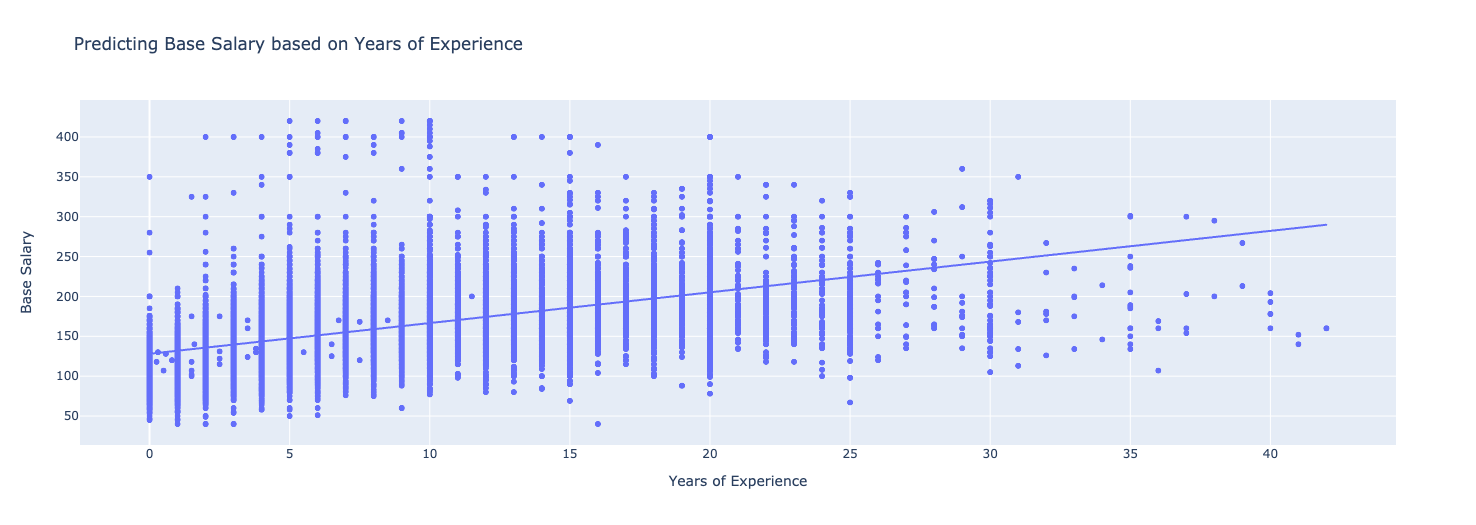

It looks like there's a positive linear relationship between years of experience and base salary!

However, does this relationship extend for all job positions? Or are there specific Computer Science roles that have a different relationship between base salary and years of experience? 

Below, we plot the years of experience against the base salary of the 7 roles we are looking to study. We will create separate scatterplots for the roles, and will again plot a line of best fit to see if there is some type of linear relationship between the two for each role. 

In [11]:
fig = px.scatter(df, x = "yearsofexperience", y = "basesalary", 
                color = "yearsatcompany", color_continuous_scale = "rainbow", facet_col = "title", facet_col_wrap = 4, trendline = "ols", 
                labels = {
                    "basesalary": "Base Salary",
                    "yearsofexperience": "Years of Experience", 
                    "facet_col": "title"
                }, title = "Predicting Base Salary based on Years of Experience")
# fig.show()

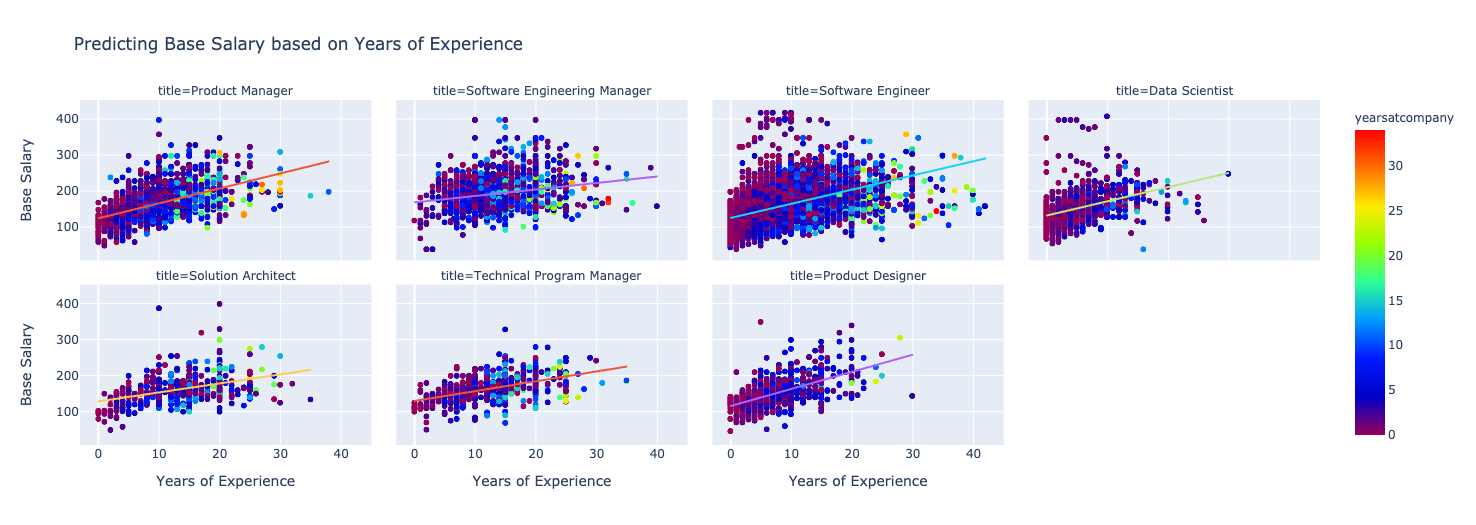

Based on the above plots, we can see a positive correlation between years of experience and base salary for each role. It looks like the base salary increases relatively slowly over years of experience for roles like Software Engineering Manager, compared to roles like Software Engineer. 

Now we want to narrow our focus to specific cities. Below, we calculate the average base salary per US city in the dataframe. 

In [12]:
# plot average salary in each city

# getting the average base salary for each city
mean_df = df[["basesalary", "City"]].groupby("City").mean().reset_index()

# getting the count for each city, we will filter on this to make sure we have adequate samples for cities we analyze
count_df = df[["City"]].value_counts().reset_index()

# renaming columns
mean_df.rename(columns = {"basesalary": "basesalary_mean"}, inplace = True)
count_df.rename(columns = {0: "count"}, inplace = True)

# we now merge our summary dataframes together
summary_df = pd.merge(mean_df, count_df, how = "inner", left_on = "City", right_on = "City")

# we merge temporarily with our main dataframe so we can get longitude/latitude coordinates, as well as the Cost of Living plus rent index
summary_df = pd.merge(summary_df, df, how = "left", left_on = "City", right_on = "City")

# columns we want to keep from past merge operation
wanted_columns = ["City", "longitude_y", "latitude_y", "basesalary_mean", "count", "Cost of Living Index", "Rent Index", "Cost of Living Plus Rent Index", "Groceries Index", "Restaurant Price Index", "Local Purchasing Power Index"]

# filtering out the unwanted columns and dropping duplicates
summary_df = summary_df[wanted_columns]
summary_df = summary_df.drop_duplicates()

# we will also remove cities with less than 30 observations, as we want to have a decent sized sample from each city
summary_df = summary_df[summary_df["count"] >= 30]

summary_df.head()

,City,longitude_y,latitude_y,basesalary_mean,count,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index
18,"Atlanta, GA",-84.390264,33.748992,122.925000,200,76.11,46.88,61.88,75.86,64.01,131.11
218,"Austin, TX",-97.743700,30.271129,134.277603,634,64.45,48.76,56.81,63.58,61.76,131.76
891,"Boston, MA",-71.058291,42.360253,137.592269,802,88.61,75.13,82.05,89.28,84.34,107.59
1698,"Charlotte, NC",-80.843083,35.227209,128.354167,48,75.70,42.20,59.39,68.67,70.50,126.48
1746,"Chicago, IL",-87.624421,41.875562,129.244966,298,82.71,55.16,69.30,80.96,75.44,109.82


First, let's take a look at what locations have the highest paying jobs. We will create a map that displays different colored circles on cities depending on their average salary to see where the higher paying jobs are located.

In [13]:
# Removes unecessary whitespace under map
from branca.element import Figure

# we use this function to color different points on our map based on salary
def color(salary):
    if salary < 100:
        return "blue"
    elif salary >= 100 and salary < 110:
        return "green"
    elif salary >= 110 and salary < 120:
        return "red"
    elif salary >= 120 and salary < 130:
        return "orange"
    elif salary >= 130 and salary < 140:
      return "yellow"
    else:
      return "black"

fig = Figure(width = 800, height = 500)
map = folium.Map(location=[40, -98], zoom_start = 4)

for i in range(0, len(summary_df)):
    folium.Circle(
        location = [summary_df.iloc[i]["latitude_y"], summary_df.iloc[i]["longitude_y"]],
        radius = 100000,
        color = color(summary_df.iloc[i]["basesalary_mean"]), 
        tooltip = "Average Base Salary: " + str(summary_df.iloc[i]["basesalary_mean"])
    ).add_to(map)
  
fig.add_child(map)
fig

As we can see from the black circles, the highest paying computer science jobs are on the coasts. However, there are still relatively high paying jobs in non-coastal areas like Pittsburgh or Austin, based on the yellow circles. 

We want to take a closer look at the 10 highest paying locations to get a better sense of the relationship between years of experience and base salary there. Once again, we plot a matrix of scatterplots below.

In [14]:
# we take the cities with the top 10 average base salary from our summary dataframe, and use that to filter our main dataframe
desired_cities = summary_df.nlargest(10, "basesalary_mean").City.tolist()

fig = px.scatter(df[df["City"].isin(desired_cities)], x = "yearsofexperience", y = "basesalary", trendline = "ols", 
                facet_col = "City", facet_col_wrap = 5,
                labels = {
                    "yearsofexperience": "Years of Experience",
                    "basesalary": "Base Salary"
                }, title = "Predicting Base Salary over Years of Experience by Location")
# fig.show()

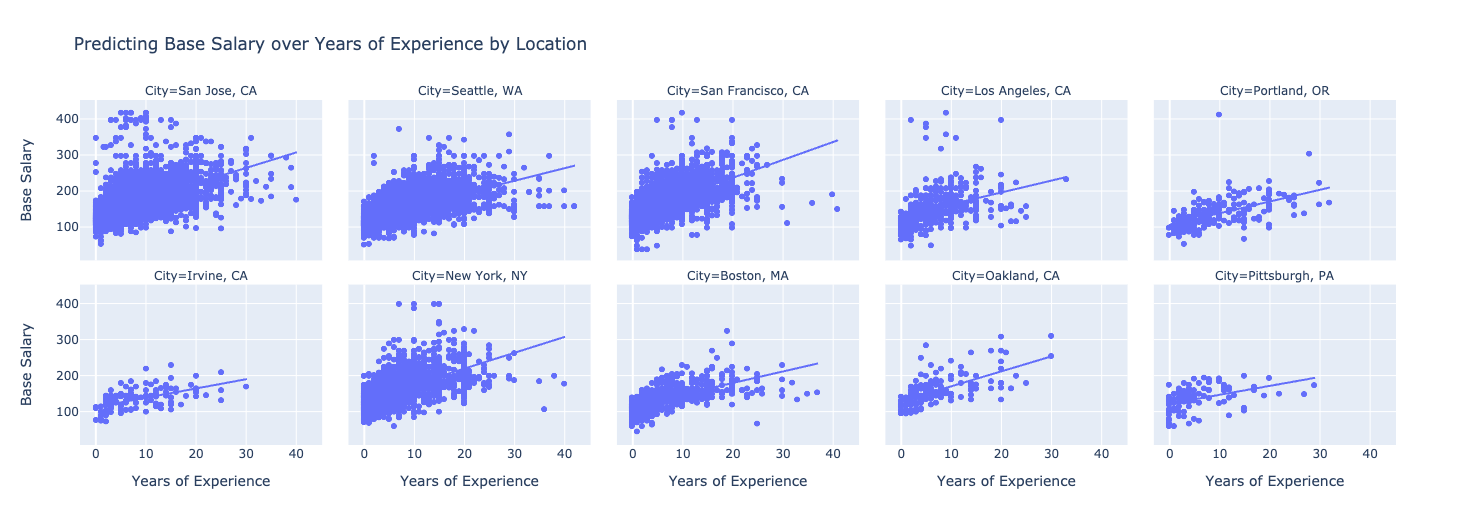

It seems that all the cities have positive linear relationships between years of experience and base salary. However, some cities, like San Francisco, have a larger increase in base salary as experience increases, as can be seen by the steeper slope in those graphs. Meanwhile, Pittsburgh and Irvine increase at slower rates. So far, based on salary alone, it seems like the Bay Area is a great place to live, and it offers high growth opportunities for employees. But is the salary worth the cost? 

Now, we turn our attention to the cost of living as it relates to salaries, locations, and other factors. First, we will compare base salary to the cost of living index of each location using another scatterplot. 

In [15]:
fig = px.scatter(df, x = "basesalary", y = "Cost of Living Index", trendline = "ols", 
                 labels = {
                     "basesalary": "Base Salary",
                 }, title = "Predicting Cost of Living Index based on Base Salary")

# fig.show() 

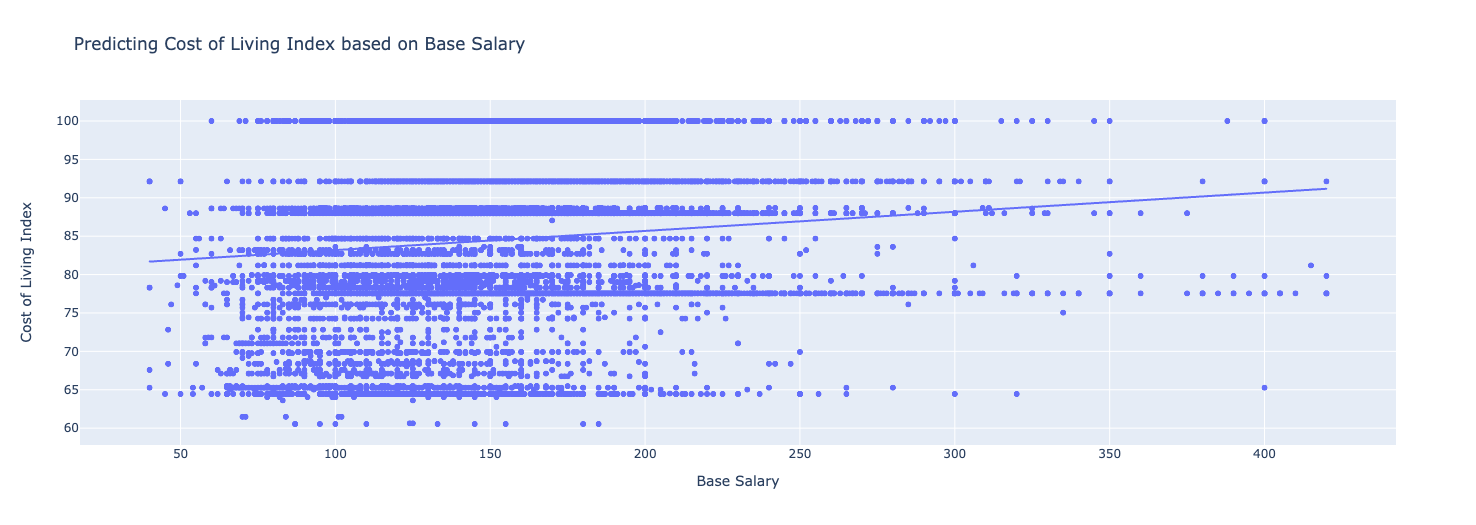

It's a little hard to tell if the above line of best fit actually represents the data well, since the points are all over the place. Thus, we'll create a matrix of correlations between base salary and the different types of cost of living indices to see if there's any more specific linear relationships. 

Text(0.5, 1.0, 'Correlation Matrix of Base Salary and Numbeo Cost of Living Indices')

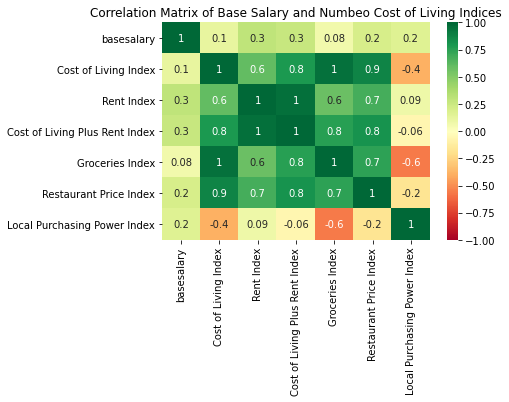

In [16]:
cols = ["basesalary", "Cost of Living Index", "Rent Index", "Cost of Living Plus Rent Index", "Groceries Index", "Restaurant Price Index", "Local Purchasing Power Index"]
sns.heatmap(df[cols].corr(), annot = True, fmt = '.1g', vmin=-1, vmax=1, center= 0, cmap= 'RdYlGn').set_title("Correlation Matrix of Base Salary and Numbeo Cost of Living Indices")

The above correlation matrix indicates that we have a slight positive relationship between base salary and every Numbeo index. The strongest relationships base salary has appear to be with Rent Index and Cost of Living Plus Rent Index, with correlations of 0.3. We'll focus on just the cost of living plus rent index. 

We've seen what the highest paying cities are, and we've seen the positive correlation between cost of living plus rent index and base salaries. Now, we're going to combine these two pieces of information together in a histogram below, which graphs the rent index of the 20 highest paying cities. 

In [17]:
# Top 20 cities
fig = px.bar(summary_df.nlargest(20, "basesalary_mean"), x = 'City', y = 'Cost of Living Plus Rent Index',
            color = 'basesalary_mean', labels = {
                 'basesalary_mean':'Average Base Salary'
                 }, height = 400, title = "Cost of Living Plus Rent Index for Top 20 Highest Paying Cities")
# fig.show()

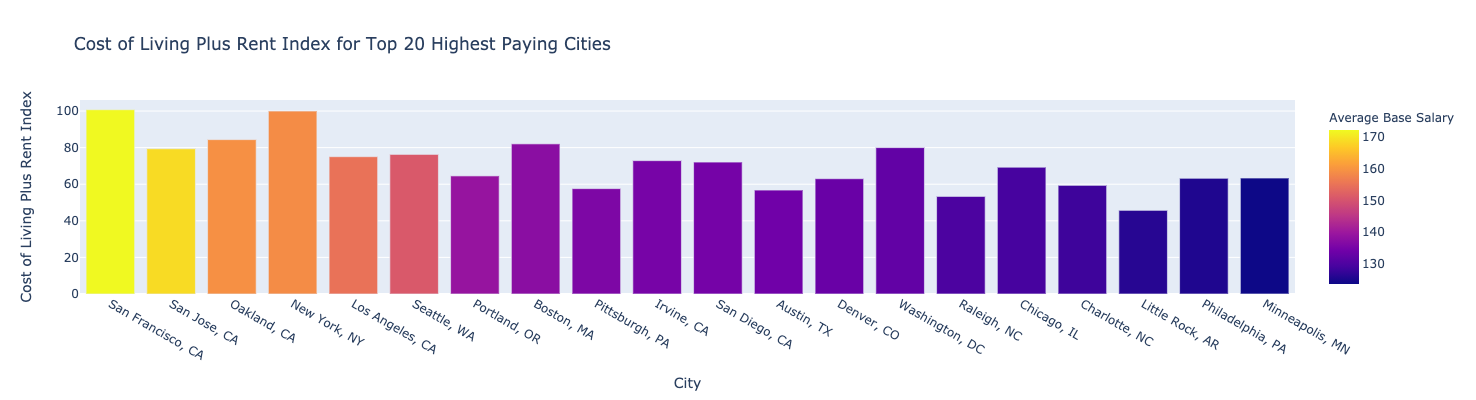

This plot highlights certain cities as being relatively expensive to live in compared to cities that pay similarly. San Francisco pays the most, but it is also extremely expensive to live in. Meanwhile, cities like New York, Boston, and Washington DC show peaks in the graph, indicating that they are relatively expensive to live in given their average salaries compared to similar cities. Meanwhile, Pittsburgh and Little Rock, for example, seem much cheaper to live in relative to otehr cities with similar average salaries, as we can see dips in the histogram at those cities. 

# Regression and Machine Learning
Now that we have analyzed the data, we can begin using the analysis to make predictions about a person's salary based on their role, years of experience, and location. We will be performing a multiple linear regression analysis to predict salary. 

Learn more about multiple linear regression here: https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-multiple-regression/mlr-with-interactions.html

Below, we use the <a href = "https://www.statsmodels.org/stable/index.html">Statsmodel</a> library to perform ordinary least squares regression with multiple interaction terms. Our null hypothesis is that there is no relationship between role, experience, location, and salary; we will analyze whether this is the case, or whether we should reject the null hypothesis. 

In [18]:
from statsmodels.formula.api import ols

# These are the cities with an adequate number of obersvations (>= 30)
cities = summary_df.City.tolist()

model = ols(formula = "basesalary ~ title + yearsofexperience + City", data = df[df["City"].isin(cities)])
reg = model.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             basesalary   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     592.3
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        20:15:15   Log-Likelihood:            -1.2833e+05
No. Observations:               26579   AIC:                         2.567e+05
Df Residuals:                   26538   BIC:                         2.571e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                99.5134      2.306     43.157      0.000      94.994     104.033
title[T.Product Designer]               -13.2936      1.410     -9.426      0.000     -16.058     -10.529
title[T.Product Manager]                 -4.9335      1.096     -4.500      0.000      -7.083      -2.785
title[T.Software Engineer]               -5.5959      0.909     -6.159      0.000      -7.377      -3.815
title[T.Software Engineering Manager]     9.0061      1.190      7.566      0.000       6.673      11.339
title[T.Solution Architect]             -11.5889      1.714     -6.761      0.000     -14.949      -8.229
title[T.Technical Program Manager]      -16.2303      1.559    -10.411      0.000     -19.286     -13.175
City[T.Austin, TX]                        8.8965      2.456      3.622      0.000       4.082      13.711
City[T.Boston, MA]                       16.2710      2.394      6.796      0.000      11.578      20.964
City[T.Charlotte, NC]                     4.1389      4.865      0.851      0.395      -5.397      13.675
City[T.Chicago, IL]                       9.2292      2.767      3.335      0.001       3.805      14.653
City[T.Columbus, OH]                     -8.5771      5.242     -1.636      0.102     -18.852       1.698
City[T.Dallas, TX]                       -0.6069      2.663     -0.228      0.820      -5.826       4.612
City[T.Denver, CO]                        6.4442      3.443      1.872      0.061      -0.304      13.193
City[T.Detroit, MI]                      -6.4634      5.138     -1.258      0.208     -16.535       3.608
City[T.Fort Lauderdale, FL]              -1.2827      5.615     -0.228      0.819     -12.289       9.724
City[T.Houston, TX]                      -2.2856      3.707     -0.617      0.538      -9.552       4.981
City[T.Irvine, CA]                        7.5517      3.316      2.278      0.023       1.053      14.050
City[T.Kansas City, MO]                 -22.4159      4.347     -5.157      0.000     -30.936     -13.896
City[T.Little Rock, AR]                   8.5714      5.418      1.582      0.114      -2.049      19.192
City[T.Los Angeles, CA]                  33.5829      2.585     12.991      0.000      28.516      38.650
City[T.Madison, WI]                       7.8771      4.645      1.696      0.090      -1.226      16.981
City[T.Minneapolis, MN]                   2.5936      3.469      0.748      0.455      -4.205       9.393
City[T.New York, NY]                     40.3661      2.228     18.121      0.000      36.000      44.732
City[T.Oakland, CA]                      36.1984      3.194     11.332      0.000      29.937      42.460
City[T.Orlando, FL]                     -19.6016      5.762     -3.402      0.001     -30.896      -8.307
City[T.Ph

As we can see in the model, most of the p-values are very low, with the exception of a handful of cities. While the null hypothesis may be applicable for those cities, overall, we can reject the null hypothesis of no relationship and use this model to predict salaries! 

As an example, we'll look at the base salary for software engineers with 0 years of experience across the country.

In [19]:
# Algorithm to rank top cities for you based on your qualifications and desired job

# These are the cities with an adequate number of obersvations (>= 30)
cities = summary_df.City.tolist()

# we could also maybe do 10-fold here ?
def rank_cities(job_title, years_of_experience):
  # let's return a pandas dataframe that includes: Job Title, Expected Salary, City, and Cost of Living
  # Will be sorted on salary
  # we can then use this same output to determine bang-for-your-buck
  result = pd.DataFrame(columns = ["title", "expectedbasesalary", "city", "costofliving"])

  numbeo_with_desired_cities = numbeo[numbeo["City"].isin(cities)]
  # iterate the rows of our desired cities to extract cost of living
  for index, row in numbeo_with_desired_cities.iterrows():
    # these are the parameters passed to the regression model, it is a dataframe with 1 row
    params = pd.DataFrame.from_dict({
        "title": [job_title], 
        "yearsofexperience": [years_of_experience],
        "Cost of Living Plus Rent Index": [row["Cost of Living Plus Rent Index"]],
        "City": [row["City"]]
    })
    
    prediction = reg.predict(params)
    # we then append our result to the end of the dataframe we return
    result.loc[len(result)] = [job_title, prediction[0], row["City"], row["Cost of Living Plus Rent Index"]]
  
  # return the result sorted by expected base salary, from highest to lowest
  return result.sort_values(by = ["expectedbasesalary"], ascending = False)

test = rank_cities("Software Engineer", 2)
test.head()

,title,expectedbasesalary,city,costofliving
1,Software Engineer,153.493407,"San Francisco, CA",100.72
16,Software Engineer,147.772411,"San Jose, CA",79.39
0,Software Engineer,141.968302,"New York, NY",100.00
2,Software Engineer,137.800580,"Oakland, CA",84.37
11,Software Engineer,135.185092,"Los Angeles, CA",75.05


Now we have a way to predict what your salary will be at a given level of experience for a given role in a specific location. We now want to figure out what city will give you the best bang for your buck - which one will pay the most while still being cheap to live in. 

To do this, we will perform the following simple calculation: 

<sup>Expected Base Salary</sup> &#8260; <sub>Cost of Living Index</sub>

Where the higher the calculated value, the more cost-effective the location is. 

Below, we'll try to figure out what the most cost-effective cities are for software engineers with 0 years of experience. 

In [20]:
# bang for your buck
# pass the df you received from rank_cities()
def best_value(df):
  # simply adds a column to the dataframe received from the previous function
  df["value"] = df["expectedbasesalary"]/df["costofliving"]

  return df.sort_values(by = ["value"], ascending = False)

test_best_value = best_value(test)

test_best_value.head()

,title,expectedbasesalary,city,costofliving,value
32,Software Engineer,110.173625,"Little Rock, AR",45.73,2.409220
13,Software Engineer,122.069347,"Pittsburgh, PA",57.59,2.119627
29,Software Engineer,109.479317,"Madison, WI",51.99,2.105776
25,Software Engineer,103.055053,"Richmond, VA",51.74,1.991787
33,Software Engineer,110.498664,"Austin, TX",56.81,1.945057


Now this is interesting! Only one of the top 10 highest paying cities seems to have a very good ratio of base salary to cost of living: Pittsburgh! But it's not even first, the number one best city to live in for software engineers with 0 experience, in terms of salary and cost of living, is Little Rock. 

This was just one example how how to use the linear model; try putting other roles or years of experiences in to see what their salary estimates and best cities are!

# Conclusion
Based on our analysis and predictions, it seems Silicon Valley is not the best place to live in terms of salary and prices. Even though cities in the Bay Area do pay a lot of money, they are so expensive that it may not be worth moving there. In fact, none of the popular coastal cities in the Top 10 seem to be cost-effective places to live in. The best bang for your buck is smaller cities and towns further from the coasts, as they have a relatively high base salary for low cost of living for various CS roles and years of experience. 

One thing to note is, because we narrowed down our data set to salaries from companies that appear many times, our data may be restricted to primarily large-scale private companies, as only they were able to provide sufficient information for analysis. It may be interesting to look deeper into other types of companies to see if the analysis changes.

We would like to give a special shoutout to Dr. John Dickerson at University of Maryland for being an outstanding professor and showing us the unlimited possibilities in the field of data science!

Feel free to build on this tutorial! This is just one example of the data science pipeline, there's so much more to explore and analyze. We plan to use the regression analysis above as a backend for a salary and cost of living calculator, for which we will build a frontend UI for. Be creative!